In [1]:
import os
import glob
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
from pprint import pprint
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, merge
from keras.models import Model
from keras.layers import Convolution2D, MaxPooling2D, Reshape, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
data_dir = "pictures/"
data_save_dir = "datasets/npy/"

Using TensorFlow backend.


In [2]:
image_paths = []
labels = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".jpg"):
            filename = os.path.join(root, file)
            image_paths.append(filename)
            s = filename.split("_")
            labels.append(float(s[1].rstrip(s[1][-4:])))
image_paths = np.array(image_paths)
labels = np.array(labels)

In [3]:
labels.shape

(1748,)

In [4]:
data = np.zeros((image_paths.shape[0], 120, 160, 3))
for i in range(image_paths.shape[0]):
    img = cv2.imread(image_paths[i])
    y1 = int(img.shape[0] / 2)
    img = img[y1:, :]
    img = cv2.resize(img, (160, 120), interpolation = cv2.INTER_CUBIC)
    data[i] = img

In [5]:
data.shape

(1748, 120, 160, 3)

In [6]:
labels = ((labels - 40) / 170.0 - 0.5) * 2

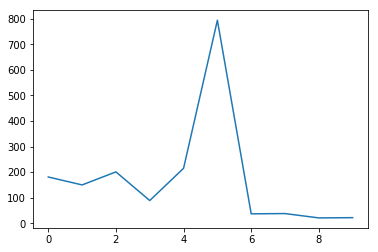

In [7]:
h = np.histogram(labels)[0]
plt.plot(h)
plt.show()

In [35]:
def AnglePredCnn():
    img_in = Input(shape=(120, 160, 3), name='img_in')                      # First layer, input layer, Shape comes from camera.py resolution, RGB
    x = img_in
    x = Convolution2D(24, (5,5), strides=(2,2), activation='relu')(x)       # 24 features, 5 pixel x 5 pixel kernel (convolution, feauture) window, 2wx2h stride, relu activation
    x = Convolution2D(32, (5,5), strides=(2,2), activation='relu')(x)       # 32 features, 5px5p kernel window, 2wx2h stride, relu activatiion
    x = Convolution2D(64, (5,5), strides=(2,2), activation='relu')(x)       # 64 features, 5px5p kernal window, 2wx2h stride, relu
    x = Convolution2D(64, (3,3), strides=(2,2), activation='relu')(x)       # 64 features, 3px3p kernal window, 2wx2h stride, relu
    x = Convolution2D(64, (3,3), strides=(1,1), activation='relu')(x)       # 64 features, 3px3p kernal window, 1wx1h stride, relu

    # Possibly add MaxPooling (will make it less sensitive to position in image).  Camera angle fixed, so may not to be needed

    x = Flatten(name='flattened')(x)                                        # Flatten to 1D (Fully connected)
    x = Dense(100, activation='linear')(x)                                    # Classify the data into 100 features, make all negatives 0
    x = Dropout(.1)(x)                                                      # Randomly drop out (turn off) 10% of the neurons (Prevent overfitting)
    x = Dense(50, activation='linear')(x)                                     # Classify the data into 50 features, make all negatives 0
    x = Dropout(.1)(x)                                                      # Randomly drop out 10% of the neurons (Prevent overfitting)
    #categorical output of the angle
    angle_out = Dense(1, activation='linear', name='angle_out')(x)        # Connect every input with every output and output 15 hidden units. Use Softmax to give percentage. 15 categories and find best one based off percentage 0.0-1.0
    
    #continous output of throttle
    throttle_out = Dense(1, activation='linear', name='throttle_out')(x)      # Reduce to 1 number, Positive number only
    
    model = Model(inputs=[img_in], outputs=[angle_out, throttle_out])
    model.compile(optimizer='adam',
                  loss={'angle_out': 'mean_squared_error',
                        'throttle_out': 'mean_squared_error'},
                  loss_weights={'angle_out': 0.9, 'throttle_out': .001})
    return model

In [36]:
model = AnglePredCnn()

In [37]:
throttle = np.zeros(labels.shape)

In [41]:
hist = model.fit(data, [labels, throttle], validation_split=0.0, epochs=10, batch_size=16)

Epoch 1/10
421/421 [==============================] - 1s 3ms/step - loss: 0.0659 - angle_out_loss: 0.0732 - throttle_out_loss: 0.0494
Epoch 2/10
421/421 [==============================] - 1s 3ms/step - loss: 0.0615 - angle_out_loss: 0.0683 - throttle_out_loss: 0.0505
Epoch 3/10
421/421 [==============================] - 1s 3ms/step - loss: 0.0589 - angle_out_loss: 0.0654 - throttle_out_loss: 0.0510
Epoch 4/10
421/421 [==============================] - 1s 4ms/step - loss: 0.0560 - angle_out_loss: 0.0621 - throttle_out_loss: 0.0466
Epoch 5/10
421/421 [==============================] - 1s 3ms/step - loss: 0.0515 - angle_out_loss: 0.0572 - throttle_out_loss: 0.0501
Epoch 6/10
421/421 [==============================] - 1s 3ms/step - loss: 0.0433 - angle_out_loss: 0.0480 - throttle_out_loss: 0.0490
Epoch 7/10
421/421 [==============================] - 1s 3ms/step - loss: 0.0400 - angle_out_loss: 0.0444 - throttle_out_loss: 0.0482
Epoch 8/10
421/421 [==============================] - 1s 3ms/s

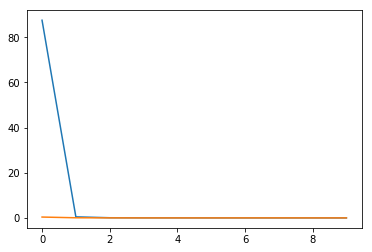

In [40]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.show()

In [42]:
model.save("models/first_turn_left.h5")